# Example Proof-of-Concept 

## Imports, Functions, & Settings

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import glob
import os
import shutil
import gzip
from nilearn import image, masking, plotting, datasets
from nilearn.input_data import NiftiMasker
import networkx as nx
from tqdm import tqdm


##########################################

import nibabel as nib
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from nilearn import plotting
from nilearn import image
from nilearn import regions
from mpl_toolkits.mplot3d import Axes3D

##########################################

from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

from nilearn.datasets import fetch_atlas_harvard_oxford
from scipy.ndimage import zoom
from tqdm import tqdm

from nilearn.datasets import load_mni152_template
from nilearn import plotting
from nilearn import datasets
from nilearn import plotting


from nilearn.plotting import plot_roi

from nilearn.image import resample_to_img

from scipy.fft import fft, fftfreq



In [3]:
# Load fMRI and anatomical data
def load_fmri_data(fmri_filepath):
    fmri_img = nib.load(fmri_filepath)
    fmri_data = fmri_img.get_fdata()
    return fmri_data

def load_anatomical_data(anatomical_filepath):
    anatomical_img = nib.load(anatomical_filepath)
    anatomical_data = anatomical_img.get_fdata()
    return anatomical_data

def load_nii(file_path):
    """Load .nii file using nibabel and return data as numpy array."""
    nii_data = nib.load(file_path)
    return nii_data.get_fdata(), nii_data.affine

## Data Extraction

In [ ]:
# gz_files = [f for f in glob(f"./data/**/*.gz", recursive=True) if os.path.isfile(f)]
# gz_files
# Extract each .gz file
# for gz_file in gz_files:
#     output_file = gz_file[:-3]  # Remove ".gz" extension

#     # Decompress the .gz file
#     with gzip.open(gz_file, 'rb') as f_in:
#         with open(output_file, 'wb') as f_out:
#             shutil.copyfileobj(f_in, f_out)

#     print(f"Extracted: {gz_file} -> {output_file}")


## Data Declaration

In [4]:

# Root directory is 'data'
root_dir = 'data'

# Glob all files that end in .nii under any 'func' directory (in nested subfolders)
func_files = glob.glob(os.path.join(root_dir, '**', 'func', '**', '*.nii'), recursive=True)

# Filter out files that contain the word 'mask' from the func_files list
func_files_without_mask = [file for file in func_files if 'mask' not in file]

# Glob all files that end in .nii under any 'anat' directory (in nested subfolders)
anat_files = glob.glob(os.path.join(root_dir, '**', 'anat', '**', '*.nii'), recursive=True)

# Glob all files that contain the word "mask" that end in .nii and are located under any 'func' directory (in nested subfolders)
func_mask_files = glob.glob(os.path.join(root_dir, '**', 'func', '**', '*mask*.nii'), recursive=True)

# Output the results
print("Func files without mask:", func_files_without_mask)
print("Anat files:", anat_files)
print("Func mask files:", func_mask_files)


Func files without mask: []
Anat files: []
Func mask files: []


## Data Visualization

### Anatomical Data Visualization

In [ ]:
index = 0
file_list_len = len(func_files_without_mask)

In [ ]:
index += 1
index %= file_list_len
# Load the compressed NIfTI file
img = nib.load(anat_files[index])

# Get image data as a NumPy array
data = img.get_fdata()

# Display a middle slice of the brain
slice_index = data.shape[2] // 2  # Middle slice in the z-dimension

plt.imshow(data[:, :, slice_index], cmap="gray")
plt.axis("off")
plt.title(f"T1-Weighted MRI Slice: \n{anat_files[index]}\n index: {index}")
plt.show()


In [ ]:
data.shape

In [ ]:
anat_files[index]

In [ ]:
img

In [ ]:
plotting.plot_anat(anat_files[index], title=f"3D Brain Visualization: \n{anat_files[index]}", threshold=0.5)

In [ ]:
anat_data_f_name = anat_files[index]
func_data_f_name = func_files_without_mask[index]

# Load the compressed NIfTI file
img = nib.load(anat_data_f_name)

# Get image data as a NumPy array
anat_data = img.get_fdata()

# Load the compressed NIfTI file
img = nib.load(func_data_f_name)

# Get image data as a NumPy array
func_data = img.get_fdata()


## Creating A Graph Representation

#### [Process](https://chatgpt.com/share/67dccc80-8f9c-8011-97b0-f044a525470d)

In [ ]:
# Intended Result:
# This method allows you to visualize the differences in brain activity between individuals using the networkx graph in a 3D space. By using Three.js, you can provide an interactive and detailed representation of the anatomical brain regions and their connections, colored by activity differences.

### Load & Preprocess Data

In [ ]:
# Load the 4D fMRI data and 3D anatomical data for each brain
brains_fmri = func_files_without_mask
brains_anatomical = anat_files

In [ ]:

# Example: Load the first brain's fMRI and anatomical data
fmri_data, fmri_affine = load_nii(brains_fmri[0])  # Shape: (x, y, z, t)
anatomical_data, anatomical_affine = load_nii(brains_anatomical[0])  # Shape: (x, y, z)


In [ ]:

# Extract regions of interest (ROIs) from anatomical data
# For simplicity, use a predefined atlas (e.g., Harvard-Oxford or AAL)
# from nilearn.datasets import load_mni152_template
# from nilearn import plotting

# Load the MNI template (in standard space) for visualization
# mni_template = load_mni152_template()

# Load an atlas, for example, Harvard-Oxford sub-cortical regions
# from nilearn import datasets
# from nilearn import plotting

# Load Harvard-Oxford sub-cortical regions (valid name: sub-maxprob-thr50-1mm)
atlas = datasets.fetch_atlas_harvard_oxford('sub-maxprob-thr50-1mm')


In [ ]:

# The atlas is returned as a dictionary with paths to the data
print(atlas.filename)  # This is the file path to the MNI space atlas


In [ ]:

# Visualize the Harvard-Oxford sub-cortical regions
plotting.plot_roi(atlas.filename, title="Harvard-Oxford Sub-Cortical Regions", display_mode='ortho', draw_cross=True)
plotting.show()

In [ ]:
# Convert the NumPy array (anatomical_data) to a NIfTI image using the affine matrix
anat_img = nib.Nifti1Image(anatomical_data, anatomical_affine)

In [ ]:

# Plot the anatomical image
plotting.plot_anat(anat_img, title="Brain Anatomy")
plotting.show()

## Extract Region Activity

In [ ]:
# Load the 4D fMRI data and 3D anatomical data for each brain
brains_fmri = func_files_without_mask
brains_anatomical = anat_files

In [ ]:
print(f"brains_fmri: {brains_fmri[0]}")
print(f"brains_anatomical: {brains_anatomical[0]}")

In [ ]:
# Example: Load the first brain's fMRI and anatomical data
fmri_data, fmri_affine = load_nii(brains_fmri[0])  # Shape: (x, y, z, t)
anatomical_data, anatomical_affine = load_nii(brains_anatomical[0])  # Shape: (x, y, z)
anatomical_nii = nib.load(brains_anatomical[0])

In [ ]:
print("Atlas shape:", anatomical_data.shape)  # Should be (X, Y, Z)
print("fMRI shape:", fmri_data.shape)  # Should be (X, Y, Z, Time)

In [ ]:
# Fetch the atlas (cortical or subcortical)

# atlas = fetch_atlas_harvard_oxford('cort-maxprob-thr25-1mm')  # 1mm resolution
# atlas_img = atlas.maps

# Fetch the cortical atlas
atlas_cortex = fetch_atlas_harvard_oxford('cort-maxprob-thr25-1mm')
atlas_img_cortex = atlas_cortex.maps

# Resample the atlas to match the anatomical image
resampled_atlas = resample_to_img(atlas_img_cortex, anatomical_nii, interpolation='nearest')
# resampled_atlas = resample_to_img(atlas_img, anatomical_nii , interpolation='nearest')

# Save the new resampled atlas
resampled_atlas.to_filename("registered_atlas.nii.gz")
plot_roi(resampled_atlas, bg_img=anatomical_nii, title="Registered Harvard-Oxford Atlas")

In [ ]:
# Fetch the sub-cortical atlas
atlas_subcortical = fetch_atlas_harvard_oxford('sub-maxprob-thr25-1mm')
atlas_img_subcortical = atlas_subcortical.filename

# Resample the atlas to match the anatomical image
resampled_atlas = resample_to_img(atlas_img_subcortical, anatomical_nii, interpolation='nearest')
# resampled_atlas = resample_to_img(atlas_img, anatomical_nii , interpolation='nearest')

# Save the new resampled atlas
resampled_atlas.to_filename("registered_atlas.nii.gz")
plot_roi(resampled_atlas, bg_img=anatomical_nii, title="Registered Harvard-Oxford Atlas")


#### Defining Regions of Interest

In [ ]:
# Convert the resampled atlas image to a NumPy array
atlas_data = resampled_atlas.get_fdata()

# Extract unique region labels from the atlas
roi_labels = np.unique(atlas_data)[1:]  # Ignore background (0)


In [ ]:
fmri_data.shape


In [ ]:
atlas_data.shape

In [ ]:
np.where(atlas_data == 1.0)

In [ ]:
# Step 1: Resample the atlas to match the spatial dimensions of fmri_data (64, 64, 34)
# Determine the scaling factors for each spatial dimension
scaling_factors = np.array(fmri_data.shape[:3]) / np.array(atlas_data.shape)

# Resample the atlas using the scaling factors (linear interpolation)
resampled_atlas = zoom(atlas_data, scaling_factors, order=1)  # Using linear interpolation

# Round and cast the resampled atlas to integers
resampled_atlas = np.round(resampled_atlas).astype(int)

# Step 2: Extract unique region labels from the resampled atlas (skip background 0)
roi_labels = np.unique(resampled_atlas)[np.unique(resampled_atlas) > 0]

# Create a dictionary to store extracted time series for each ROI
roi_time_series = {}

# Step 3: Extract fMRI time series for each ROI
for roi in tqdm(roi_labels, desc="Processing ROIs"):
    # Get the voxel indices for the current ROI in the resampled atlas
    roi_voxels = np.where(resampled_atlas == roi)

    # Ensure the voxel indices are valid within the spatial dimensions of fmri_data
    # Extract the fMRI signal corresponding to these voxels for each time point
    roi_signal = fmri_data[roi_voxels].mean(axis=0)  # Averaging across voxels (axis 0 refers to spatial)

    # Store the resulting time series for the current ROI
    roi_time_series[roi] = roi_signal


In [ ]:
roi_labels

In [ ]:
roi_time_series

In [ ]:
# Convert to DataFrame
roi_df = pd.DataFrame(roi_time_series)


In [ ]:
roi_df.head()

In [ ]:
roi_df

In [ ]:
roi_df.iloc[:, 0]

In [ ]:
# Save as CSV
roi_df.to_csv("roi_activity.csv", index=False)


In [ ]:
# Plot an example ROI signal
plt.plot(roi_df.iloc[:, 0], label = atlas_subcortical.labels[1])  # Plot the first region
plt.xlabel("Time")
plt.ylabel("BOLD Signal")
plt.title("Region Activity Over Time")
plt.legend()
plt.show()

In [ ]:
index = 0

In [ ]:
# Plot an example ROI signal
plt.plot(roi_df.iloc[:, index], label = atlas_subcortical.labels[index+1])  # Plot the first region
plt.xlabel("Time")
plt.ylabel("BOLD Signal")
plt.title(f"{atlas_subcortical.labels[index+1]} Region Activity Over Time")
plt.legend()
plt.grid(True)
plt.show()
index +=1
index %= roi_df.shape[1]

### Calculating the ALFF/fALFF and the Bold Variability

In [ ]:
index = 0

In [ ]:
roi_df.iloc[:, index]

In [ ]:
# Parameters
TR = 2 # Repetition time (in seconds)
low_freq_band = (0.01, 0.1) # Low-frequency range for ALFF (Hz)
n_timepoints = roi_df.shape[0]
frequencies = fftfreq(n_timepoints, d=TR)
fft_data = fft(roi_df.iloc[:, index], axis=-1)


In [ ]:
roi_df.iloc[:, 0]

In [ ]:

# Create a mask for the low-frequency band
low_freq_mask = np.logical_and(frequencies >= low_freq_band[0], frequencies <= low_freq_band[1])

# Compute the ALFF: average amplitude in the low-frequency band
alff = np.abs(fft_data)[..., low_freq_mask].mean(axis=-1)

# For fALFF: Compute the total power in the 0.01-0.25 Hz range
total_power = np.abs(fft_data)[..., (frequencies >= 0.01) & (frequencies <= 0.25)].sum(axis=-1)

# Compute fALFF: Normalized ALFF
falff = alff / total_power


In [ ]:
# BOLD Signal Variability (e.g., using Coefficient of Variation)
cv = np.std(roi_df.iloc[:, index]) / np.mean(roi_df.iloc[:, index])

In [ ]:
falff

In [ ]:
cv

# Next Steps


- [ ] Creating region_activities all_brains:  a list of dictionaries, where each dictionary maps region names to activity levels
- [ ] regions: atlas.labels[1:]
- [ ] brains_fmri: exists
- [ ] Improvement: increase granularity by having multiple signals from regions where regions correspond to Link-sized regions with 1024 BOLD temporal signals
- [ ] Compute the Activity Difference
- [ ] Create the Graph
- [ ] Export the graph data
- [ ] visualize
- [ ] host visualization on github pages
- [ ] include sub-cortical regions
- [ ] cluster the data by age, handedness, sex, and education
- [ ] cluster by health, MCI, and Demented
- [ ] evaluate level of stimulation to apply to achieve normal cognitive status
- [ ] simulate applying stimulation to MCI or Demented to achieve Healthy Cognitive Function


## Acquiring All Signals For all Brains

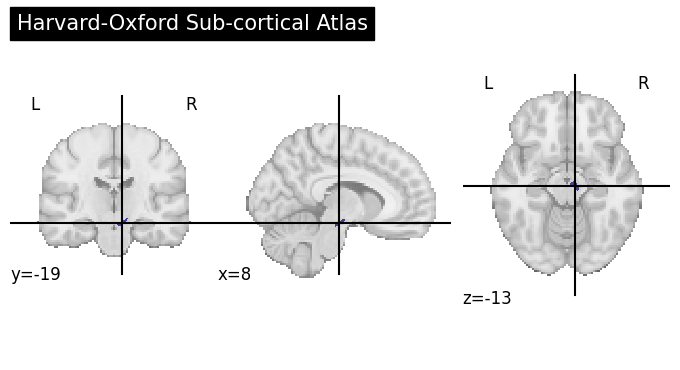

In [34]:
from nilearn import datasets, plotting

# Fetch the Harvard-Oxford sub-cortical atlas (probabilistic)
atlas_filename = "../data/atlas/NMS-SNc-atlas-master/SN_R_probatlas27_50.nii.gz"

# Plot the atlas to view the regions including substantia nigra
plotting.plot_roi(atlas_filename, title="Harvard-Oxford Sub-cortical Atlas", display_mode="ortho", draw_cross=True)


In [33]:
atlas_filename

'../data/atlas/NMS-SNc-atlas-master/SN_L_probatlas27_50.nii.gz'

In [32]:
import nibabel as nib
import numpy as np

# Load the atlas NIfTI image
atlas_img = nib.load(atlas_filename)

# Get the image data as a numpy array
atlas_data = atlas_img.get_fdata()

# Find the nonzero voxel coordinates (i.e., where the atlas has nonzero values)
voxel_coords = np.argwhere(atlas_data > 0)

# Convert voxel coordinates to real-world (MNI or scanner) space
affine = atlas_img.affine
world_coords = nib.affines.apply_affine(affine, voxel_coords)

# Print first few coordinates
print(world_coords[:10])


[[ -2. -21. -18.]
 [ -2. -21. -17.]
 [ -2. -20. -17.]
 [ -2. -20. -16.]
 [ -2. -19. -16.]
 [ -2. -19. -15.]
 [ -3. -22. -19.]
 [ -3. -22. -18.]
 [ -3. -21. -19.]
 [ -3. -21. -18.]]


In [30]:

# Load the AAL Atlas
atlas = datasets.fetch_atlas_aal()

[get_dataset_dir] Dataset found in /home/linux-pc/nilearn_data/aal_SPM12

[fetch_single_file] Downloading data from https://www.gin.cnrs.fr/AAL_files/aal_for_SPM12.tar.gz ...

[fetch_single_file] Error while fetching file aal_for_SPM12.tar.gz; dataset fetching aborted.

SSLError: HTTPSConnectionPool(host='www.gin.cnrs.fr', port=443): Max retries exceeded with url: /AAL_files/aal_for_SPM12.tar.gz (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.gin.cnrs.fr'. (_ssl.c:1007)")))

In [29]:
pd.DataFrame(flat_list).to_csv("temp.csv", index=False)

In [23]:
matches = [(i, item) for i, item in enumerate(flat_list) if "Substantia Nigra" in item]

print(matches)  
# Output: [(2, 'Substantia Nigra Left'), (4, 'Substantia Nigra Right')]


[]


In [5]:
atlas_filename = datasets.fetch_atlas_harvard_oxford('sub-cortical')['filename']

ValueError: Invalid atlas name: sub-cortical. Please choose an atlas among:
cort-maxprob-thr0-1mm
cort-maxprob-thr0-2mm
cort-maxprob-thr25-1mm
cort-maxprob-thr25-2mm
cort-maxprob-thr50-1mm
cort-maxprob-thr50-2mm
cort-prob-1mm
cort-prob-2mm
cortl-maxprob-thr0-1mm
cortl-maxprob-thr0-2mm
cortl-maxprob-thr25-1mm
cortl-maxprob-thr25-2mm
cortl-maxprob-thr50-1mm
cortl-maxprob-thr50-2mm
cortl-prob-1mm
cortl-prob-2mm
sub-maxprob-thr0-1mm
sub-maxprob-thr0-2mm
sub-maxprob-thr25-1mm
sub-maxprob-thr25-2mm
sub-maxprob-thr50-1mm
sub-maxprob-thr50-2mm
sub-prob-1mm
sub-prob-2mm

In [ ]:
# Fetch the atlas (cortical or subcortical)
atlas_cortex = fetch_atlas_harvard_oxford('cort-maxprob-thr25-1mm')  # 1mm resolution
atlas_img_cortex = atlas.filename

# Fetch the sub-cortical atlas
atlas_subcortical = fetch_atlas_harvard_oxford('sub-maxprob-thr25-1mm')
atlas_img_subcortical = atlas_subcortical.filename

# Load the Harvard-Oxford Sub-cortical Atlas
# from nilearn import datasets
# atlas_filename = datasets.fetch_atlas_harvard_oxford('sub-cortical')['filename']

# Plot the Harvard-Oxford Sub-cortical Atlas overlaid on the fMRI data
# plotting.plot_roi(atlas_filename, bg_img=fmri_data, title="Harvard-Oxford Sub-cortical Atlas")


atlas_labels = atlas_cortex.labels[1:] + atlas_subcortical.labels[1:]

# Root directory is 'data'
root_dir = '../data'

# Glob all files that end in .nii under any 'func' directory (in nested subfolders)
func_files = glob.glob(os.path.join(root_dir, '**', 'func', '**', '*.nii.gz'), recursive=True)

# Filter out files that contain the word 'mask' from the func_files list
func_files_without_mask = [file for file in func_files if 'mask' not in file]

# Glob all files that end in .nii under any 'anat' directory (in nested subfolders)
anat_files = glob.glob(os.path.join(root_dir, '**', 'anat', '**', '*.nii.gz'), recursive=True)

# Glob all files that contain the word "mask" that end in .nii and are located under any 'func' directory (in nested subfolders)
func_mask_files = glob.glob(os.path.join(root_dir, '**', 'func', '**', '*mask*.nii.gz'), recursive=True)

# Output the results
print("Func files without mask:", func_files_without_mask)
print("Anat files:", anat_files)
print("Func mask files:", func_mask_files)

NameError: name 'fetch_atlas_harvard_oxford' is not defined

In [ ]:
# Load the 4D fMRI data and 3D anatomical data for each brain
brains_fmri = func_files_without_mask
brains_anatomical = anat_files

In [ ]:
len(brains_anatomical)

In [ ]:
len(brains_fmri)

In [ ]:
# Create Bold Signals For All Subcortical and Cortical Regions
for person in tqdm(range(len(brains_fmri))):
    bold_signal_dir = os.path.dirname(os.path.dirname(brains_fmri[person]))
    subject_name = os.path.basename(os.path.dirname(os.path.dirname(os.path.dirname(brains_fmri[person]))))
    # Example: Load the first brain's fMRI and anatomical data
    fmri_data, fmri_affine = load_nii(brains_fmri[person])  # Shape: (x, y, z, t)
    anatomical_data, anatomical_affine = load_nii(brains_anatomical[person])  # Shape: (x, y, z)
    anatomical_nii = nib.load(brains_anatomical[person])
    
    # Resample the atlas to match the anatomical image (cortical)
    resampled_atlas_cortex = resample_to_img(atlas_img_cortex, anatomical_nii , interpolation='nearest')
    resampled_atlas_subcortex = resample_to_img(atlas_img_subcortical, anatomical_nii , interpolation='nearest')
    
    # Save the new resampled atlas
    # resampled_atlas.to_filename("registered_atlas.nii.gz")
    
    # Convert the resampled atlas image to a NumPy array
    atlas_data_cortex = resampled_atlas_cortex.get_fdata()
    atlas_data_subcortex = resampled_atlas_subcortex.get_fdata()
    
    # Extract unique region labels from the atlas
    roi_labels_cortex = np.unique(atlas_data_cortex)[1:]  # Ignore background (0)
    roi_labels_subcortex = np.unique(atlas_data_subcortex)[1:]  # Ignore background (0)roi_labels_cortex = np.unique(atlas_data_cortex)[1:]  # Ignore background (0)

    # Step 1: Resample the atlas to match the spatial dimensions of fmri_data (64, 64, 34)
    # Determine the scaling factors for each spatial dimension
    scaling_factors = np.array(fmri_data.shape[:3]) / np.array(atlas_data_cortex.shape)

    # Resample the atlas using the scaling factors (linear interpolation)
    resampled_atlas_cortex = zoom(atlas_data_cortex, scaling_factors, order=1)  # Using linear interpolation
    resampled_atlas_subcortex = zoom(atlas_data_subcortex, scaling_factors, order=1) # Using linear inerpolation

    # Round and cast the resampled atlas to integers
    resampled_atlas_cortex = np.round(resampled_atlas_cortex).astype(int)
    resampled_atlas_subcortex = np.round(resampled_atlas_subcortex).astype(int)

    # Step 2: Extract unique region labels from the resampled atlas (skip background 0)
    # roi_labels = np.unique(resampled_atlas)[np.unique(resampled_atlas) > 0]

    # Create a dictionary to store extracted time series for each ROI
    roi_time_series = {}

    # Step 3: Extract fMRI time series for each ROI
    for roi in tqdm(roi_labels_cortex, desc="Processing ROIs"):
        # Get the voxel indices for the current ROI in the resampled atlas
        roi_voxels = np.where(resampled_atlas_cortex == roi)

        # Ensure the voxel indices are valid within the spatial dimensions of fmri_data
        # Extract the fMRI signal corresponding to these voxels for each time point
        roi_signal = fmri_data[roi_voxels].mean(axis=0)  # Averaging across voxels (axis 0 refers to spatial)

        # Store the resulting time series for the current ROI
        roi_time_series[roi] = roi_signal

    # Convert to DataFrame
    roi_cortex_df = pd.DataFrame(roi_time_series)

    # Create a dictionary to store extracted time series for each ROI
    roi_time_series = {}

    # Step 3: Extract fMRI time series for each ROI
    for roi in tqdm(roi_labels_subcortex, desc="Processing ROIs"):
        # Get the voxel indices for the current ROI in the resampled atlas
        roi_voxels = np.where(resampled_atlas_subcortex == roi)

        # Ensure the voxel indices are valid within the spatial dimensions of fmri_data
        # Extract the fMRI signal corresponding to these voxels for each time point
        roi_signal = fmri_data[roi_voxels].mean(axis=0)  # Averaging across voxels (axis 0 refers to spatial)

        # Store the resulting time series for the current ROI
        roi_time_series[roi] = roi_signal

    # Convert to DataFrame
    roi_subcortex_df = pd.DataFrame(roi_time_series)
    roi_df = pd.concat([roi_cortex_df, roi_subcortex_df], axis=1)
    roi_df.columns = atlas_labels

    f_path = bold_signal_dir + '/' + subject_name + "_roi_BOLD_activity.csv"

    # Save as CSV
    bold_signal_dir
    # roi_df.to_csv(f_path, index=False)


## Collecting CSV of BOLD Activity

In [ ]:
# Load the 4D fMRI data and 3D anatomical data for each brain
brains_fmri = func_files_without_mask
brains_anatomical = anat_files

In [ ]:
BOLD_activity_csv_list =[f for f in glob.glob("data/**/*.csv", recursive=True) if "dataframes" not in f ]

In [ ]:
BOLD_activity_csv_list

In [ ]:
# Fetch the atlas (cortical or subcortical)
atlas_cortex = fetch_atlas_harvard_oxford('cort-maxprob-thr25-1mm')  # 1mm resolution
atlas_img_cortex = atlas_cortex.filename

# Fetch the sub-cortical atlas
atlas_subcortical = fetch_atlas_harvard_oxford('sub-maxprob-thr25-1mm')
atlas_img_subcortical = atlas_subcortical.filename

atlas_labels = atlas_cortex.labels[1:] + atlas_subcortical.labels[1:]
atlas_labels

In [ ]:
BOLD_activity_df_list = []
for person in BOLD_activity_csv_list:
    BOLD_activity_df_list.append(pd.read_csv(person))

##### Computing fractional Amplitude Low Frequency Fluctuations & Coefficient of Variance

In [ ]:
fALFF_df = pd.DataFrame(columns=["Subject"] + atlas_labels)
cv_df = pd.DataFrame(columns=["Subject"] + atlas_labels)

In [ ]:
# Parameters
TR = 2 # Repetition time (in seconds)
low_freq_band = (0.01, 0.1) # Low-frequency range for ALFF (Hz)
n_timepoints = 300
frequencies = fftfreq(n_timepoints, d=TR)
# Create a mask for the low-frequency band
low_freq_mask = np.logical_and(frequencies >= low_freq_band[0], frequencies <= low_freq_band[1])

In [ ]:
fft(BOLD_activity_df_list[0].iloc[:, 1], axis=-1)

In [ ]:
for temp_df in BOLD_activity_df_list:
    for region in range(len(temp_df.columns)):
        # print(temp_df.iloc[:, region])
        print(temp_df.columns)

In [ ]:
temp_df.columns

In [ ]:
temp_df.iloc[:]

In [ ]:
for temp_df in BOLD_activity_df_list:
    for region in range(len(temp_df.columns)):
        print(temp_df.iloc[:, region])
        print(type(region))
        # fft_data = fft(temp_df.iloc[:, region], axis=-1)

In [ ]:
# Calculate Frequencies and CV
person = 0
for temp_df in tqdm(BOLD_activity_df_list):
    subject_name = os.path.basename(os.path.dirname(os.path.dirname(os.path.dirname(brains_fmri[person]))))
    fALFF_values = []
    cv_values = []
    for region in range(len(temp_df.columns)):
        fft_data = fft(temp_df.iloc[:, region], axis=-1)
        
        # Compute the ALFF: average amplitude in the low-frequency band
        alff = np.abs(fft_data)[..., low_freq_mask].mean(axis=-1)

        # For fALFF: Compute the total power in the 0.01-0.25 Hz range
        total_power = np.abs(fft_data)[..., (frequencies >= 0.01) & (frequencies <= 0.25)].sum(axis=-1)

        # Compute fALFF: Normalized ALFF
        falff = alff / total_power
        fALFF_values.append(falff)
        
        # BOLD Signal Variability (e.g., using Coefficient of Variation)
        cv = np.std(temp_df.iloc[:, region]) / np.mean(temp_df.iloc[:, region])
        cv_values.append(cv)
    
    # Create the new row with "Subject" and the numerical values
    new_row = {'Subject': subject_name}  # Add the string value for 'Subject'
    new_row.update(dict(zip(atlas_labels, fALFF_values)))  # Add numerical values to the other columns
    fALFF_df.loc[len(fALFF_df)] = new_row
    
    new_row = {'Subject': subject_name}
    new_row.update(dict(zip(atlas_labels, cv_values)))
    cv_df.loc[len(cv_df)] = new_row
    person+=1
        


In [ ]:
len(BOLD_activity_df_list)

In [ ]:
len(subject_name_l)

In [ ]:
df_dir = "data/dataframes/BOLD/"
for df in tqdm(range(len(BOLD_activity_df_list))):
    BOLD_activity_df_list[df].to_csv(df_dir + subject_name_l[df] + "_BOLD.csv", index=False)
    

In [ ]:
fALFF_df.head()

In [ ]:
cv_df.head()

In [ ]:
# Set the 'Subject' column as the index for easy access
fALFF_df.set_index('Subject', inplace=True)
cv_df.set_index('Subject', inplace=True)


In [ ]:
# save fALFF_df & cv df
fALFF_df.to_csv("data/dataframes/fALFF.csv")  # Save without the index
cv_df.to_csv("data/dataframes/cv_df.csv")


In [ ]:
# Acquiring subject names:
subject_name_l = []
for person in range(len(brains_fmri)):
    subject_name = os.path.basename(os.path.dirname(os.path.dirname(os.path.dirname(brains_fmri[person]))))
    subject_name_l.append(subject_name)

In [ ]:
subject_name_df = pd.DataFrame(subject_name_l, columns=['Name'])

In [ ]:
subject_name_df.head()

In [ ]:
subject_name_df.to_csv("data/dataframes/subject_name_df.csv", index = False)

## Visualize the fALFF & CV

In [ ]:
# Load fALFF & CV
fALFF_df = pd.read_csv("data/dataframes/fALFF.csv", index_col=0)
cv_df = pd.read_csv("data/dataframes/cv_df.csv", index_col=0)
subject_name_df = pd.read_csv("data/dataframes/subject_name_df.csv")

In [ ]:
subject_name_df.head()

In [ ]:
fALFF_df.head()

In [ ]:
cv_df.head()

In [ ]:
BOLD_activity_df_list[0]

In [ ]:
# Create an empty bipartite graph
B = nx.Graph()

# Add nodes for subjects (bipartite set 1)
B.add_nodes_from(fALFF_df.index, bipartite=0)

# Add nodes for regions (bipartite set 2)
regions = fALFF_df.columns.tolist()  # All regions are the columns of fALFF_df
B.add_nodes_from(regions, bipartite=1)

# Add edges between subjects and regions with two distinct weights (one from fALFF_df and one from cv_df)
for subject in fALFF_df.index:
    for region in fALFF_df.columns:
        weight1 = fALFF_df.at[subject, region]  # Weight from fALFF_df
        weight2 = cv_df.at[subject, region]  # Weight from cv_df
        
        # Add an edge with two distinct weights
        B.add_edge(subject, region, weight_fALFF=weight1, weight_cv=weight2)

# Now the graph B contains bipartite nodes (subjects and regions) with edges having two distinct weights

# Example: Print the edges with weights from both dataframes
for u, v, data in B.edges(data=True):
    print(f"Edge ({u}, {v}) - Weight from fALFF_df: {data['weight_fALFF']}, Weight from cv_df: {data['weight_cv']}")


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Set positions for bipartite layout with increased spacing
pos = {}
pos.update((node, (1, index * 2.5)) for index, node in enumerate(fALFF_df.index))  # Subjects (left side)
pos.update((node, (4, index * 2.5)) for index, node in enumerate(regions))  # Regions (right side)

# Get edge weights from the fALFF_df's weight column
edge_weights = [B[u][v]['weight_fALFF'] for u, v in B.edges()]

# Normalize edge thickness for better visibility
max_weight = max(edge_weights) if edge_weights else 1  # Avoid division by zero
edge_widths = [1 + 6 * (w / max_weight) for w in edge_weights]  # Scale thickness between 1 and 7

# Normalize edge color mapping
norm = mcolors.Normalize(vmin=min(edge_weights), vmax=max(edge_weights))
cmap = cm.Blues
edge_colors = [cmap(norm(w)) for w in edge_weights]

# Set larger figure size
plt.figure(figsize=(24, 16))  # Bigger canvas for better visibility

# Draw the bipartite graph with smaller nodes
edges = nx.draw_networkx_edges(
    B, pos, edge_color=edge_colors, width=edge_widths, edge_cmap=cmap, alpha=0.8
)
nodes = nx.draw_networkx_nodes(B, pos, node_size=800, node_color='skyblue')  # Smaller nodes
labels = nx.draw_networkx_labels(B, pos, font_size=12, font_weight='bold')

# Add colorbar legend for edge weights
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca(), orientation='vertical', fraction=0.02, pad=0.02)
cbar.set_label("Edge Weight (fALFF)", fontsize=14)

# Title
plt.title("Optimized Bipartite Graph with Improved Spacing and Smaller Nodes", fontsize=16)

# Show the plot
plt.show()



In [ ]:
# Select the region to visualize
region_to_visualize = "Frontal Pole"

# Create an empty graph
B = nx.Graph()

# Add the central brain region node
B.add_node(region_to_visualize, color='Teal', size=3000)

# Add subject nodes and edges
for subject in fALFF_df.index:
    weight1 = fALFF_df.at[subject, region_to_visualize]  # fALFF weight
    weight2 = cv_df.at[subject, region_to_visualize] if region_to_visualize in cv_df.columns else 0  # CV weight
    
    B.add_node(subject, color='green', size=1500)  # Subject nodes
    B.add_edge(subject, region_to_visualize, weight1=weight1, weight2=weight2)  # Edge with weights

# Set figure size **before drawing**
plt.figure(figsize=(18, 14))  # Larger figure size for better visibility

# Positioning: Use `spring_layout` with a **higher `k` value** to spread nodes more
pos = nx.spring_layout(B, seed=42, k=1.5)  # Increase k for wider spacing

# Draw nodes with custom sizes and colors
node_colors = [B.nodes[node]['color'] for node in B.nodes()]
node_sizes = [B.nodes[node]['size'] for node in B.nodes()]
nx.draw(B, pos, with_labels=True, node_size=node_sizes, node_color=node_colors, font_size=12, font_weight='bold')

# Draw edges with labels (4 decimal places)
edge_labels = {
    (u, v): f"fALFF: {B[u][v]['weight1']:.4f}\nCV: {B[u][v]['weight2']:.4f}" 
    for u, v in B.edges()
}
nx.draw_networkx_edge_labels(B, pos, edge_labels=edge_labels, font_size=10)

# Title
plt.title(f"Graph Representation: '{region_to_visualize}' Connected to Subjects", fontsize=14)

# Show the plot
plt.show()


## Computing the Activity Difference

In [ ]:
import networkx as nx
import numpy as np

# Initialize the graph
G = nx.Graph()

# Assuming `region_activities_all_brains` is a list of dictionaries, where each dictionary maps region names to activity levels
# regions = List of brain regions
# brains_fmri = List of brain names or identifiers

# Loop through each pair of brains (individuals)
for i, brain_1 in enumerate(brains_fmri):
    for j, brain_2 in enumerate(brains_fmri):
        if i < j:  # Make sure you don't compare the same brain to itself
            # Loop through each region to calculate the difference for each region separately
            for region in regions:
                # Calculate the absolute difference in activity for this region between the two brains
                activity_diff = np.abs(region_activities_all_brains[i][region] - region_activities_all_brains[j][region])
                
                # Add an edge between the two brains for this region, with weight as the activity difference for this region
                G.add_edge(f"{brain_1}_{region}", f"{brain_2}_{region}", weight=activity_diff)

# Now `G` contains edges where each edge represents the activity difference for a specific region between two brains.


Key Points:

    Graph Structure: Each pair of brains (brain_1 and brain_2) has a separate edge for each region in the brain, with the edge weight representing the difference in activity for that specific region.
    Edges Represent Region-Specific Differences: The graph G will have edges named like brain_1_region_name to brain_2_region_name, where region_name corresponds to a specific brain region (e.g., "hippocampus", "prefrontal_cortex", etc.). The weight of the edge will represent the difference in activity for that region.

Example of the Graph Structure:

    If there are three brains (brain_1, brain_2, brain_3) and three regions (region_1, region_2, region_3), the graph will have edges like:
        brain_1_region_1 to brain_2_region_1 (weight = difference in activity for region_1 between brain_1 and brain_2)
        brain_1_region_2 to brain_2_region_2 (weight = difference in activity for region_2 between brain_1 and brain_2)
        etc.

Usage:

    You can then visualize the graph, where each region will have its own node connecting the brains.
    You can also use this graph to explore how the activity differences between individual brains vary across regions, which could give insights into specific regional brain activity changes between individuals.

If you'd like to visualize or analyze the resulting graph, you can plot the graph using matplotlib, networkx's built-in plotting functions, or any other visualization library you prefer.

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Assuming `G` is your networkx graph (created in the previous step)

# Set up the figure
plt.figure(figsize=(12, 12))

# Draw the networkx graph
pos = nx.spring_layout(G, k=0.15, iterations=20)  # Layout for positioning nodes
nx.draw(G, pos, with_labels=True, node_size=500, node_color="lightblue", font_size=10, font_weight="bold", edge_color='gray')

# Add edge labels (weights for the activity differences)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Display the plot
plt.title("Brain Activity Differences Between Individuals")
plt.show()


Explanation:

    spring_layout: This layout is good for general graph visualization. It arranges nodes in 2D space with a force-directed algorithm.
    nx.draw(): Draws the nodes and edges.
    nx.draw_networkx_edge_labels(): Displays the edge labels, which in this case are the activity differences between regions for each brain pair.

This Python code will provide a basic 2D visualization. However, for a 3D interactive plot, you need to export the data and use it with Three.js.
Step 2: 3D Visualization with Three.js

To visualize the same graph in 3D using Three.js, we need to:

    Export the graph data (nodes and edges with weights) into a format that Three.js can use (like JSON).
    Create the Three.js scene to visualize the nodes and edges.

2.1: Exporting the Graph Data to JSON (Python)



In [ ]:
import json

# Prepare graph data in a format suitable for Three.js
graph_data = {
    "nodes": [],
    "edges": []
}

# Add nodes (brains and regions)
for node in G.nodes:
    # Extract brain and region from node (e.g., brain_1_region_1)
    brain, region = node.split('_')
    graph_data["nodes"].append({
        "id": node,
        "brain": brain,
        "region": region
    })

# Add edges (activity differences between brain pairs)
for u, v, data in G.edges(data=True):
    graph_data["edges"].append({
        "source": u,
        "target": v,
        "weight": data["weight"]
    })

# Save to a JSON file
with open("graph_data.json", "w") as f:
    json.dump(graph_data, f)


This will generate a graph_data.json file that contains the nodes (with regions and brain identifiers) and edges (with weights representing the activity differences).
2.2: Setting Up Three.js for 3D Visualization

Now, let’s create the 3D visualization in Three.js. Below is an example of how you can visualize the nodes and edges of your graph in 3D.

Here is the basic Three.js setup:

In [ ]:
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Brain Activity Differences Visualization</title>
    <style>
        body { margin: 0; overflow: hidden; }
        canvas { display: block; }
    </style>
</head>
<body>

<script src="https://cdnjs.cloudflare.com/ajax/libs/three.js/r128/three.min.js"></script>
<script src="https://cdnjs.cloudflare.com/ajax/libs/three.js/r128/OrbitControls.min.js"></script>

<script>
// Set up the 3D scene, camera, and renderer
const scene = new THREE.Scene();
const camera = new THREE.PerspectiveCamera(75, window.innerWidth / window.innerHeight, 0.1, 1000);
const renderer = new THREE.WebGLRenderer();
renderer.setSize(window.innerWidth, window.innerHeight);
document.body.appendChild(renderer.domElement);

// Load graph data from the JSON file
fetch('graph_data.json')
    .then(response => response.json())
    .then(graphData => {
        const nodes = graphData.nodes;
        const edges = graphData.edges;

        // Add nodes to the scene (each node is a sphere)
        const nodeRadius = 0.5;
        const nodeGeometry = new THREE.SphereGeometry(nodeRadius, 16, 16);
        const nodeMaterial = new THREE.MeshBasicMaterial({ color: 0x00ff00 });
        const nodeMeshes = {};

        nodes.forEach(node => {
            const nodeMesh = new THREE.Mesh(nodeGeometry, nodeMaterial);
            // Random positions for nodes, but can be improved later with better layout algorithms
            nodeMesh.position.set(Math.random() * 10 - 5, Math.random() * 10 - 5, Math.random() * 10 - 5);
            scene.add(nodeMesh);
            nodeMeshes[node.id] = nodeMesh;
        });

        // Add edges between nodes (lines)
        const edgeMaterial = new THREE.LineBasicMaterial({ color: 0x0000ff });
        edges.forEach(edge => {
            const source = nodeMeshes[edge.source];
            const target = nodeMeshes[edge.target];
            if (source && target) {
                const points = [];
                points.push(source.position);
                points.push(target.position);
                const lineGeometry = new THREE.BufferGeometry().setFromPoints(points);
                const line = new THREE.Line(lineGeometry, edgeMaterial);
                scene.add(line);
            }
        });

        // Set up the camera position
        camera.position.z = 20;

        // Add orbit controls to move around the scene
        const controls = new THREE.OrbitControls(camera, renderer.domElement);

        // Animation loop
        function animate() {
            requestAnimationFrame(animate);
            
            // Update the controls to enable interaction
            controls.update(); // only required if controls.enableDamping or controls.auto-rotation is enabled
            
            renderer.render(scene, camera);
        }
        animate();
    });

</script>

</body>
</html>


Explanation:

    Three.js Setup: The script sets up a basic 3D scene with a camera, lighting, and controls for rotating the view.
    Graph Data: The graph data (graph_data.json) is loaded into the scene. Nodes are visualized as spheres, and edges are represented as lines connecting the nodes.
    Node and Edge Visualization: The nodes are positioned randomly for simplicity, but you can improve the layout with algorithms such as force-directed layout. The edges are created by connecting pairs of nodes.

How to Host on GitHub:

    Push the graph_data.json file and your Three.js HTML file to your GitHub repository.
    Use GitHub Pages to serve your index.html file. You can enable this in the repository settings.

Final Thoughts:

    3D Visualization: The above Three.js code gives a basic 3D interactive view of the graph. You can further refine the visualization by adjusting the node placement, adding better color schemes, and improving the camera interaction.
    Interactivity: With OrbitControls, you can rotate, zoom, and pan the scene, making it easier to inspect the graph.

### Host the 3D visualization on GitHub Pages

To host your 3D visualization on GitHub, you can follow these steps:
Step 1: Create a GitHub Repository

    Go to GitHub: Navigate to GitHub.
    Create a New Repository:
        Click the + icon in the top right corner and select "New repository."
        Name your repository, for example, brain-visualization.
        Optionally, add a description.
        Set the repository to "Public."
        Initialize with a README file.
        Click "Create repository."

Step 2: Upload Your Files to GitHub

    Clone Your Repository:
        Copy the repository URL (e.g., https://github.com/your-username/brain-visualization.git).
        Open a terminal and clone the repository to your local machine:

    git clone https://github.com/your-username/brain-visualization.git
    cd brain-visualization

Add Your Files:

    Place your HTML file (index.html) and any required assets (such as 3D brain model files, JavaScript files, etc.) inside this repository folder on your local machine.

Add and Commit the Changes:

    In your terminal, add all files and commit them:

    git add .
    git commit -m "Initial commit with 3D brain visualization"

Push the Changes:

    Push the changes to GitHub:

        git push origin main

Step 3: Host the Site Using GitHub Pages

    Navigate to the Repository Settings:
        Go to your GitHub repository.
        Click on the Settings tab at the top of the page.

    Enable GitHub Pages:
        Scroll down to the GitHub Pages section.
        In the Source dropdown, select the main branch.
        Click Save.

    Access the Hosted Site:
        After a few moments, your site will be live at https://your-username.github.io/brain-visualization/.

Step 4: Update the Files (If Needed)

    Any changes you make locally can be updated to GitHub Pages by following these steps:
        Edit your files locally.
        Add, commit, and push the changes:

        git add .
        git commit -m "Updated the 3D brain visualization"
        git push origin main

Your changes will be reflected on the live site after a few moments.
Step 5: Access the Model and Scripts

Make sure that any assets you reference in your code (e.g., the 3D brain model .obj, JS files, etc.) are either:

    Uploaded to the repository and referenced with relative paths, or
    Hosted externally (e.g., from a CDN) and referenced via URLs.

For example:

    If you uploaded the brain model as brain_model.obj to the repository, reference it like this in your index.html:

    loader.load('brain_model.obj', function (object) {
        scene.add(object);
        object.scale.set(2, 2, 2);  // Adjust size
    });

If your brain model is hosted on a CDN or another server, use its full URL in place of 'brain_model.obj'.
Step 6: Debug and Test

    After hosting the site, test it by navigating to the GitHub Pages URL in your browser.
    If you encounter issues with file paths or assets, ensure the file paths are correct and relative to the GitHub Pages root directory.

Example File Structure:

brain-visualization/
├── index.html
├── brain_model.obj
├── script.js
└── styles.css

By following these steps, you'll have your 3D brain visualization up and running on GitHub Pages!


### Creating a Brain Model

1. Python Code for Brain Model Export (same as before)

This Python code will load your NIfTI anatomical data, generate a 3D brain model, and save it as an .obj file.



In [ ]:

import nibabel as nib
import numpy as np
import pyvista as pv
from skimage import measure

# Load the NIfTI data (e.g., anatomical brain scan)
nii_file = 'path_to_your_brain_data.nii'  # Change this to the path of your NIfTI file
nii_img = nib.load(nii_file)
data = nii_img.get_fdata()

# Create a binary mask: threshold the data to get the brain's surface
threshold = np.max(data) * 0.3  # You can adjust the threshold value
binary_mask = data > threshold

# Extract the surface (isosurface) from the binary mask
verts, faces, _, _ = measure.marching_cubes(binary_mask, level=threshold)

# Convert to a PyVista mesh
mesh = pv.PolyData(verts, faces)

# Optionally, save the 3D brain model to a file format like STL or OBJ
mesh.save('brain_model.obj')  # Save as OBJ for 3D visualization in Three.js


#### Three.js code to visualize the brain model

In [ ]:
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Brain Activity Differences Visualization</title>
    <style>
        body { margin: 0; overflow: hidden; }
        canvas { display: block; }
    </style>
</head>
<body>

<script src="https://cdnjs.cloudflare.com/ajax/libs/three.js/r128/three.min.js"></script>
<script src="https://cdnjs.cloudflare.com/ajax/libs/three.js/r128/OrbitControls.min.js"></script>
<script src="https://cdnjs.cloudflare.com/ajax/libs/three.js/r128/loaders/OBJLoader.js"></script>

<script>
// Set up the 3D scene, camera, and renderer
const scene = new THREE.Scene();
const camera = new THREE.PerspectiveCamera(75, window.innerWidth / window.innerHeight, 0.1, 1000);
const renderer = new THREE.WebGLRenderer();
renderer.setSize(window.innerWidth, window.innerHeight);
document.body.appendChild(renderer.domElement);

// Load the brain model OBJ file
const objLoader = new THREE.OBJLoader();
objLoader.load('brain_model.obj', (object) => {
    // Add the brain model to the scene
    object.scale.set(2, 2, 2);  // Adjust scale if needed
    scene.add(object);
});

// Set up the camera position
camera.position.z = 20;

// Add orbit controls to move around the scene
const controls = new THREE.OrbitControls(camera, renderer.domElement);

// Animation loop
function animate() {
    requestAnimationFrame(animate);
    controls.update();  // Update controls (necessary for OrbitControls)
    renderer.render(scene, camera);
}
animate();
</script>

</body>
</html>


### Visualizing brains side-by-side

Visualizing two anatomically correct brains in Three.js with the ability to compare regions, display differences in brain activity, and simulate the effects of electrical stimulation can be a complex task. Below is a step-by-step guide to implement this functionality, breaking it down into parts:
1. Set Up Two Anatomically Correct Brains in Three.js

    First, you'll need the 3D models for the brain anatomy (e.g., .obj, .stl, or .gltf format).
    These models must have predefined regions for easy matching between the two brains.

2. Create the Scene and Load Brain Models

    We'll load two 3D models of brains and display them side-by-side in the same 3D scene.
    Use THREE.js to load and display the models.

3. Add Edges Between Matching Regions of the Two Brains

    We'll create edges between matching regions of the two brains. The edge weights (colors) will be based on the difference in activity between the regions.

4. Add Interactivity (Brain Selection)

    Add UI elements to select which brain (on the left and right) to compare.
    Use HTML or React for the interface, and update the visualization dynamically.

5. Color the Edges Based on Activity Difference

    The edges should change color based on the difference in activity (e.g., using a color gradient from green to red).

6. Simulate Electrical Stimulation

    For a specific brain region, simulate electrical stimulation by modifying the activity levels in that region.
    Update the brain visualization in real-time to show how stimulation impacts the activity in the affected regions, restoring cognitive abilities.

Example Code for Step 1–5:

In [ ]:
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Brain Comparison and Stimulation</title>
    <style>
        body { margin: 0; overflow: hidden; }
        canvas { display: block; }
        #controls { position: absolute; top: 20px; left: 20px; z-index: 10; color: white; }
    </style>
</head>
<body>
    <div id="controls">
        <label for="brainSelectLeft">Left Brain:</label>
        <select id="brainSelectLeft">
            <option value="brain1">Brain 1</option>
            <option value="brain2">Brain 2</option>
        </select>

        <label for="brainSelectRight">Right Brain:</label>
        <select id="brainSelectRight">
            <option value="brain3">Brain 3</option>
            <option value="brain4">Brain 4</option>
        </select>
    </div>

<script src="https://cdnjs.cloudflare.com/ajax/libs/three.js/r128/three.min.js"></script>
<script src="https://cdnjs.cloudflare.com/ajax/libs/three.js/r128/OrbitControls.min.js"></script>

<script>
// Create the 3D scene, camera, and renderer
const scene = new THREE.Scene();
const camera = new THREE.PerspectiveCamera(75, window.innerWidth / window.innerHeight, 0.1, 1000);
const renderer = new THREE.WebGLRenderer();
renderer.setSize(window.innerWidth, window.innerHeight);
document.body.appendChild(renderer.domElement);

// Load brain models (using placeholders for now)
const brain1Mesh = new THREE.Mesh(new THREE.SphereGeometry(5, 32, 32), new THREE.MeshBasicMaterial({ color: 0x00ff00 }));
const brain2Mesh = new THREE.Mesh(new THREE.SphereGeometry(5, 32, 32), new THREE.MeshBasicMaterial({ color: 0x0000ff }));

brain1Mesh.position.set(-10, 0, 0);
brain2Mesh.position.set(10, 0, 0);

scene.add(brain1Mesh);
scene.add(brain2Mesh);

// Initialize OrbitControls
const controls = new THREE.OrbitControls(camera, renderer.domElement);

// Set camera position
camera.position.z = 50;

// Activity difference (for demonstration, using random values for edges)
const regions = ['Region A', 'Region B', 'Region C'];
const activityDifferences = {
    'Region A': { 'Region A': 0, 'Region B': 0.5, 'Region C': 0.2 },
    'Region B': { 'Region A': 0.5, 'Region B': 0, 'Region C': 0.3 },
    'Region C': { 'Region A': 0.2, 'Region B': 0.3, 'Region C': 0 },
};

// Add edges between matching regions (edges will be colored based on activity difference)
const edges = [];
regions.forEach(region1 => {
    regions.forEach(region2 => {
        if (region1 !== region2) {
            const activityDiff = activityDifferences[region1][region2];
            const edgeColor = new THREE.Color(0xff0000).lerp(new THREE.Color(0x00ff00), 1 - activityDiff);
            edges.push({ region1, region2, activityDiff, color: edgeColor });
        }
    });
});

// Create edges (lines) between brain regions
edges.forEach(edge => {
    const material = new THREE.LineBasicMaterial({ color: edge.color });
    const geometry = new THREE.Geometry();
    geometry.vertices.push(new THREE.Vector3(Math.random() * 5, Math.random() * 5, Math.random() * 5)); // Random position for demonstration
    geometry.vertices.push(new THREE.Vector3(Math.random() * 5, Math.random() * 5, Math.random() * 5)); // Random position for demonstration

    const line = new THREE.Line(geometry, material);
    scene.add(line);
});

// Update function for UI interactivity
document.getElementById('brainSelectLeft').addEventListener('change', updateScene);
document.getElementById('brainSelectRight').addEventListener('change', updateScene);

// Simulate brain stimulation
function updateScene() {
    // Logic to update the scene (e.g., adjust the brain model and edge colors)
    // You can update the positions or properties of regions based on the selected brains
    console.log('Updating scene based on selected brains');
}

// Animate the scene
function animate() {
    requestAnimationFrame(animate);

    controls.update();
    renderer.render(scene, camera);
}

animate();
</script>
</body>
</html>


1. Brain Models:

    Replace the placeholder brain models (SphereGeometry) with actual 3D brain models (e.g., .obj, .stl, .gltf). You can load these models with THREE.OBJLoader, THREE.GLTFLoader, etc.

2. Comparing Brain Regions:

    In this code, the activityDifferences object holds the activity differences between regions, represented as a value between 0 (no difference) and 1 (maximum difference). You can dynamically update this based on real data.
    The edges are visualized as lines between regions, with color gradients reflecting the activity difference (from green to red).

3. Simulate Brain Stimulation:

    For each brain, select a region and simulate stimulation by increasing or decreasing the activity. After stimulation, the model should be updated to reflect the normalized activity in the selected region.

4. Interactivity:

    HTML dropdowns (brainSelectLeft and brainSelectRight) allow users to select which two brains they want to compare.
    When the selection changes, the scene can be updated by changing the models and edge colors.

5. Future Enhancements:

    Better Layout: For real brain region positioning, use a layout algorithm (e.g., spherical or customized) or data from an anatomical atlas.
    Simulation: Implement electrical stimulation by modifying activity levels of specific regions and updating the visualization.

6. Simulating Stimulation:

    Create a function to simulate electrical stimulation. For example, you could gradually increase the activity of a specific region and see how it affects the brain's behavior.